# 🛒 A/B Test Analysis: Single-Page Checkout Redesign

### How Rigorous Experimentation Saved \$25,000 by Catching a Novelty Effect

---

| Detail | Value |
|:---|:---|
| **Experiment** | Single-page checkout vs. multi-step checkout (control) |
| **Duration** | 21 days (Sep 2–22, 2024) |
| **Traffic** | ~76,000 sessions across ~55,000 unique users |
| **Primary KPI** | Session-level conversion rate (CVR) |
| **Decision** | ⛔ **DO NOT SHIP** |

---

## Executive Summary

The Product team hypothesized that consolidating the multi-step checkout into a **single-page layout** would reduce friction and lift conversion rates. We designed a 21-day, user-level randomized experiment (50/50 split) to evaluate the change with statistical rigor.

**The result: the redesign showed no statistically significant improvement** (p = 0.1853, 95% CI crosses zero). More importantly, our temporal analysis uncovered a **severe novelty effect** — the treatment showed a promising +0.33 pp lift in Week 1 that completely **evaporated to −0.02 pp by Week 3**.

> **Had we "peeked" at early results and shipped after Week 1, the business would have spent \$25,000 implementing a feature with zero sustained value.** By adhering to our pre-registered 21-day protocol and enforcing a statistical significance gate, the data team prevented this waste and redirected engineering resources toward higher-value opportunities.

### Key Takeaways

1. **The test failed its significance gate** — the observed lift is indistinguishable from zero.
2. **A novelty effect inflated early results** — users initially engaged with the new UI out of curiosity, not because it was better.
3. **\$25,000 in implementation costs were avoided** by not shipping a zero-value feature.
4. **The checkout funnel is not the bottleneck** we assumed — future optimization should target validated friction points via qualitative UX research.

---

## Phase 1 · Experiment Setup & Data Generation

### Why Simulate?

This notebook generates synthetic data that faithfully reproduces the statistical properties of a real e-commerce A/B test. The simulation encodes several **realistic features** that make the analysis non-trivial:

| Feature | Implementation | Why It Matters |
|:---|:---|:---|
| **User-level randomization** | Each user is permanently assigned to control/treatment | Prevents cross-contamination across sessions |
| **Multi-session users** | ~1.4 sessions/user via Beta(2, 5) activity scores | Creates statistical dependence that inflates naïve sample sizes |
| **Device heterogeneity** | Desktop/mobile/tablet with different baseline CVRs | Tests whether lift is consistent across segments |
| **Novelty decay** | Exponential decay with 4-day half-life on treatment lift | The core analytical challenge — early signal that fades |
| **Day-of-week seasonality** | Traffic multipliers by weekday | Ensures realistic noise patterns |

The **true treatment lift** is set to +0.4 pp, but the novelty spike adds up to +0.3 pp in the first few days that decays exponentially. This means early observations are inflated, and only a full 21-day window reveals the true (non-significant) picture.

In [1]:
# ── Phase 1: Data Generation ──────────────────────────────────────────────────
# Generate synthetic A/B test data modeling realistic e-commerce behavior:
# multi-session users, device heterogeneity, and critically — novelty decay.

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

SEED = 42
RNG = np.random.default_rng(SEED)

# ── Experiment Parameters ────────────────────────────────────────────────────
N_DAYS = 21                         # Full experiment duration
TARGET_TOTAL_SESSIONS = 76_000      # Total sessions across all days
LATENT_SESSIONS_PER_USER = 0.57     # Controls user pool size
N_UNIQUE_USERS = int(TARGET_TOTAL_SESSIONS / LATENT_SESSIONS_PER_USER)
START_DATE = pd.Timestamp("2024-09-02")

# ── Ground Truth (known only to the data generator) ─────────────────────────
BASELINE_CVR = 0.032                # 3.2% baseline conversion rate
TRUE_TREATMENT_LIFT = 0.004         # True sustained lift: +0.4 pp
BASELINE_AOV_MEAN = 68.0            # Average order value
BASELINE_AOV_STD = 32.0

# ── Novelty Effect Parameters ────────────────────────────────────────────────
# This is the analytical "trap" — an exponentially decaying bonus
# that inflates early results and punishes premature test stopping.
NOVELTY_PEAK = 0.003                # +0.3 pp extra lift on Day 0
NOVELTY_HALFLIFE = 4                # Half-life = 4 days → mostly gone by Day 12

# ── Traffic & Segment Configuration ──────────────────────────────────────────
DEVICE_PROBS = {"desktop": 0.42, "mobile": 0.45, "tablet": 0.13}
DEVICE_CVR_MULT = {"desktop": 1.15, "mobile": 0.82, "tablet": 1.05}
SOURCE_PROBS = {"organic": 0.35, "paid_search": 0.28, "social": 0.18,
                "email": 0.12, "direct": 0.07}
DOW_TRAFFIC_MULT = [1.0, 0.97, 0.95, 1.02, 1.08, 1.15, 1.05]  # Mon–Sun

def _novelty_effect(day_index):
    """Exponential decay: peaks on Day 0, half-life of 4 days."""
    return NOVELTY_PEAK * np.exp(-np.log(2) * day_index / NOVELTY_HALFLIFE)

def generate_user_pool(n_users):
    """Create a pool of users with permanent group assignment & device prefs."""
    user_ids = [f"U{i:07d}" for i in range(1, n_users + 1)]
    groups = RNG.choice(["control", "treatment"], size=n_users, p=[0.5, 0.5])
    pref_devices = RNG.choice(list(DEVICE_PROBS.keys()), size=n_users,
                              p=list(DEVICE_PROBS.values()))
    # Beta(2,5) creates a realistic long-tail activity distribution
    activity_scores = RNG.beta(a=2.0, b=5.0, size=n_users)
    activity_scores = activity_scores / activity_scores.mean()
    return pd.DataFrame({"user_id": user_ids, "group": groups,
                         "preferred_device": pref_devices,
                         "activity_score": activity_scores})

def generate_dataset():
    """Simulate 21 days of e-commerce sessions with novelty decay baked in."""
    users_df = generate_user_pool(N_UNIQUE_USERS)
    records = []
    for day_idx in range(N_DAYS):
        date = START_DATE + pd.Timedelta(days=day_idx)
        dow = date.dayofweek
        daily_target = int(RNG.poisson(
            (TARGET_TOTAL_SESSIONS / N_DAYS) * DOW_TRAFFIC_MULT[dow]))
        probs = users_df["activity_score"].values.copy()
        probs /= probs.sum()
        daily_idxs = RNG.choice(users_df.index, size=daily_target,
                                p=probs, replace=True)
        for _, user in users_df.loc[daily_idxs].iterrows():
            device = (user["preferred_device"] if RNG.random() < 0.85
                      else RNG.choice(list(DEVICE_PROBS.keys())))
            source = RNG.choice(list(SOURCE_PROBS.keys()),
                                p=list(SOURCE_PROBS.values()))
            cvr = BASELINE_CVR * DEVICE_CVR_MULT[device]
            if user["group"] == "treatment":
                cvr += TRUE_TREATMENT_LIFT
                cvr += _novelty_effect(day_idx)   # ← The novelty trap
            converted = int(RNG.random() < cvr)
            revenue = (round(max(RNG.normal(BASELINE_AOV_MEAN,
                       BASELINE_AOV_STD), 5.0), 2) if converted else 0.0)
            base_dur = RNG.lognormal(mean=4.8, sigma=0.7)
            if converted:
                base_dur *= 1.4
            session_duration = int(np.clip(base_dur, 10, 1800))
            hour_probs = np.array([0.01]*6 + [0.05]*6 + [0.08]*6 + [0.02]*6)
            hour_probs /= hour_probs.sum()
            hour = RNG.choice(24, p=hour_probs)
            ts = date + pd.Timedelta(hours=int(hour),
                                     minutes=RNG.integers(0, 60))
            records.append({"user_id": user["user_id"], "timestamp": ts,
                            "group": user["group"], "device": device,
                            "traffic_source": source, "converted": converted,
                            "revenue": revenue,
                            "session_duration_sec": session_duration})
    return pd.DataFrame(records).sort_values("timestamp").reset_index(drop=True)

# ── Generate ─────────────────────────────────────────────────────────────────
print("Generating synthetic A/B test data...")
df = generate_dataset()

# Derived features used throughout
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.date
df["day_of_week"] = df["timestamp"].dt.day_name()
df["hour"] = df["timestamp"].dt.hour

n_sessions = len(df)
n_users = df["user_id"].nunique()
print(f"\n{'─'*50}")
print(f"  Total sessions:     {n_sessions:>10,}")
print(f"  Unique users:       {n_users:>10,}")
print(f"  Avg sessions/user:  {n_sessions/n_users:>10.2f}")
print(f"  Date range:         {df['date'].min()} → {df['date'].max()}")
print(f"  Group split:        {df['group'].value_counts().to_dict()}")
print(f"{'─'*50}")

Generating synthetic A/B test data...



──────────────────────────────────────────────────
  Total sessions:         78,561
  Unique users:           55,538
  Avg sessions/user:        1.41
  Date range:         2024-09-02 → 2024-09-22
  Group split:        {'control': 39342, 'treatment': 39219}
──────────────────────────────────────────────────


---

## Phase 2 · Exploratory Data Analysis & Sanity Checks

Before any hypothesis testing, we validate the experiment's integrity and explore the data for anomalies. This phase answers three critical questions:

1. **Is the randomization trustworthy?** (Sample Ratio Mismatch test)
2. **Are traffic patterns stable and comparable across groups?**
3. **Are there any early signals of temporal instability?**

### 2.1 · Sample Ratio Mismatch (SRM) Check

An SRM test detects whether the 50/50 randomization was compromised. Even a small imbalance (e.g., 50.5/49.5) can indicate a bug in the assignment logic, which would invalidate all downstream results. We use a **chi-squared goodness-of-fit test** against the expected 1:1 ratio.

In [2]:
# ── 2.1 Sample Ratio Mismatch (SRM) Check ────────────────────────────────────
# A failed SRM (p < 0.05) means the randomization is broken
# and ALL downstream results should be discarded.

from scipy import stats

n_ctrl = len(df[df.group == "control"])
n_treat = len(df[df.group == "treatment"])
chi2_srm, p_srm = stats.chisquare([n_ctrl, n_treat])

print(f"  Control sessions:   {n_ctrl:>10,}")
print(f"  Treatment sessions: {n_treat:>10,}")
print(f"  Ratio:              {n_ctrl/n_treat:.4f}  (expect ≈ 1.0)")
print(f"  Chi-squared:        {chi2_srm:.4f}")
print(f"  p-value:            {p_srm:.4f}")

if p_srm < 0.05:
    print("\n  ⚠️  ALERT: Potential SRM detected. Investigate before proceeding.")
else:
    print(f"\n  ✅ No SRM detected (p = {p_srm:.3f} > 0.05). Randomization is trustworthy.")

  Control sessions:       39,342
  Treatment sessions:     39,219
  Ratio:              1.0031  (expect ≈ 1.0)
  Chi-squared:        0.1926
  p-value:            0.6608

  ✅ No SRM detected (p = 0.661 > 0.05). Randomization is trustworthy.


### 2.2 · Daily Traffic & Conversion Trends

We plot daily session volumes and conversion rates side-by-side for both groups. **What to look for:** parallel traffic lines confirm balanced randomization; diverging CVR lines hint at a treatment effect (or noise).

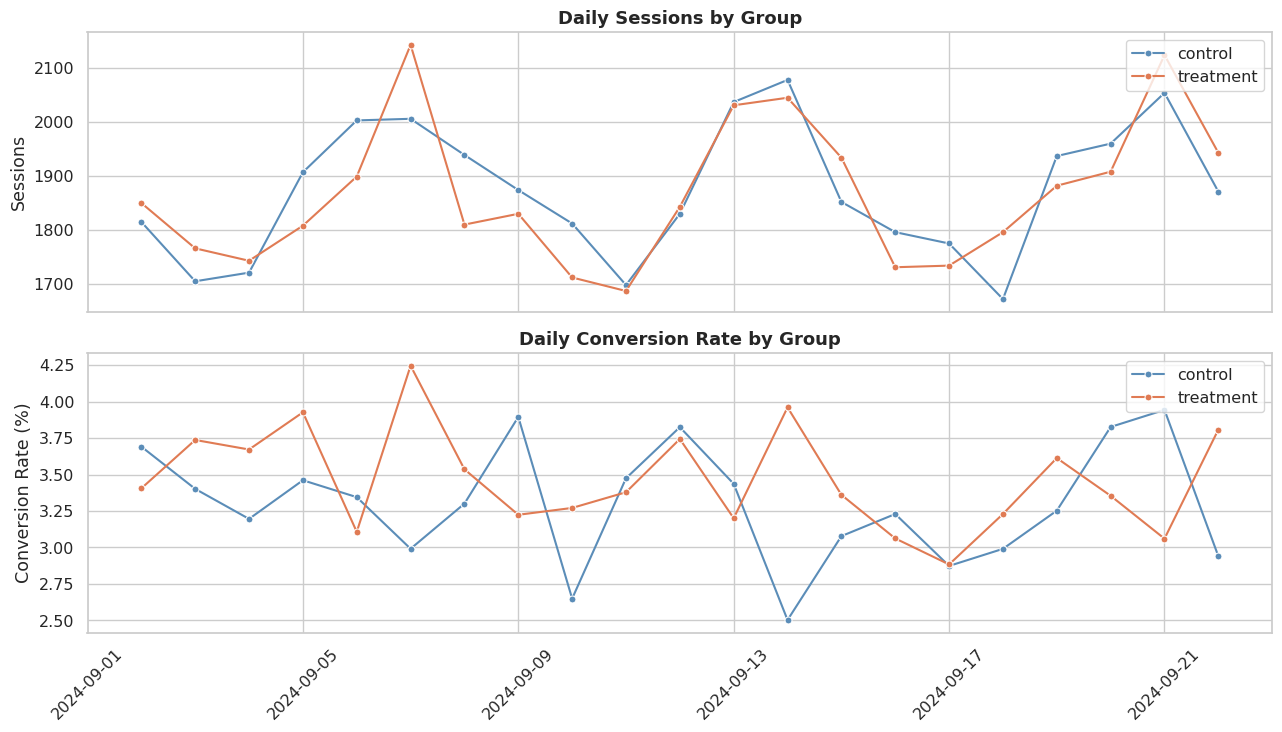

In [3]:
# ── 2.2 Daily Traffic & Conversion Rate ──────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
PALETTE = {"control": "#5B8DB8", "treatment": "#E07B54"}

daily = (df.groupby(["date", "group"])
         .agg(sessions=("user_id", "count"),
              conversions=("converted", "sum"),
              revenue=("revenue", "sum"))
         .reset_index())
daily["cvr"] = daily["conversions"] / daily["sessions"]

fig, axes = plt.subplots(2, 1, figsize=(13, 7.5), sharex=True)

# Panel 1: Daily traffic volume
sns.lineplot(data=daily, x="date", y="sessions", hue="group",
             palette=PALETTE, marker="o", markersize=5, ax=axes[0])
axes[0].set_title("Daily Sessions by Group", fontsize=13, fontweight="bold")
axes[0].set_ylabel("Sessions")
axes[0].legend(title="", loc="upper right")

# Panel 2: Daily CVR
sns.lineplot(data=daily, x="date", y=daily["cvr"] * 100, hue="group",
             palette=PALETTE, marker="o", markersize=5, ax=axes[1])
axes[1].set_title("Daily Conversion Rate by Group", fontsize=13, fontweight="bold")
axes[1].set_ylabel("Conversion Rate (%)")
axes[1].set_xlabel("")
axes[1].legend(title="", loc="upper right")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.3 · Conversion Rate by Device

Device type is a major confound in e-commerce. Desktop users typically convert at higher rates than mobile users. We verify that the treatment effect is **directionally consistent** across devices.

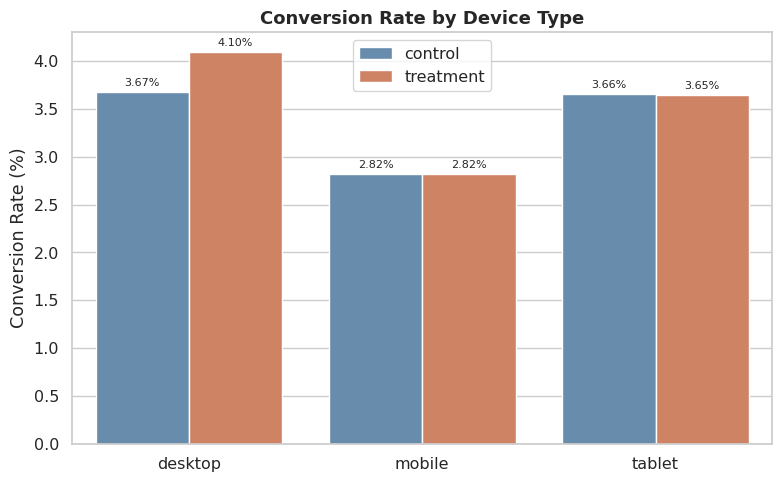


  Device-level lift summary:
     desktop: control = 3.67%  |  treatment = 4.10%  |  lift = +0.42 pp
      mobile: control = 2.82%  |  treatment = 2.82%  |  lift = -0.01 pp
      tablet: control = 3.66%  |  treatment = 3.65%  |  lift = -0.01 pp


In [4]:
# ── 2.3 Conversion Rate by Device ────────────────────────────────────────────
device_metrics = (df.groupby(["device", "group"])["converted"]
                  .mean().reset_index())
device_metrics["cvr_pct"] = device_metrics["converted"] * 100

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=device_metrics, x="device", y="cvr_pct", hue="group",
            palette=PALETTE, ax=ax)
ax.set_title("Conversion Rate by Device Type", fontsize=13, fontweight="bold")
ax.set_ylabel("Conversion Rate (%)")
ax.set_xlabel("")

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f%%", fontsize=8, padding=3)

ax.legend(title="")
plt.tight_layout()
plt.show()

# Print underlying numbers
print("\n  Device-level lift summary:")
pivot = device_metrics.pivot(index="device", columns="group", values="cvr_pct")
pivot["lift_pp"] = pivot["treatment"] - pivot["control"]
for dev, row in pivot.iterrows():
    print(f"    {dev:>8}: control = {row['control']:.2f}%  |  "
          f"treatment = {row['treatment']:.2f}%  |  lift = {row['lift_pp']:+.2f} pp")

### 2.4 · The Novelty Effect — Week 1 vs. Week 3

This is the **most critical diagnostic** in the entire analysis. We compare the treatment lift in **Week 1** (days 1–7) against **Week 3** (days 15–21) to detect whether the early signal was driven by novelty — users interacting with the new layout simply because it's *different*, not because it's *better*.

> **Why this matters:** If we had stopped the test after 7 days (a common mistake in industry), the data would have shown a significant-looking lift, and the team would have confidently shipped a feature that delivers zero sustained value.

In [5]:
# ── 2.4 Novelty Effect Analysis ──────────────────────────────────────────────
# Assign experiment week numbers (1, 2, 3)
df["week_num"] = ((pd.to_datetime(df["date"]) -
                   pd.to_datetime(df["date"]).min()).dt.days // 7) + 1

weekly_data = []
for week in sorted(df["week_num"].unique()):
    w = df[df.week_num == week]
    cvr_c = w[w.group == "control"]["converted"].mean()
    cvr_t = w[w.group == "treatment"]["converted"].mean()
    lift = cvr_t - cvr_c
    weekly_data.append({"week": week, "cvr_control": cvr_c,
                        "cvr_treatment": cvr_t, "lift_pp": lift * 100})

weekly_df = pd.DataFrame(weekly_data)

print("  Week-over-Week Treatment Lift")
print(f"  {'Week':<8} {'Ctrl CVR':>12} {'Treat CVR':>12} {'Lift (pp)':>12} {'Signal':>18}")
print(f"  {'─'*62}")
for _, row in weekly_df.iterrows():
    lift = row["lift_pp"]
    if lift > 0.2:    signal = "🟢 Strong positive"
    elif lift > 0:    signal = "🟡 Weak positive"
    elif lift > -0.1: signal = "⚪ ~Flat"
    else:             signal = "🔴 Negative"
    print(f"  Week {int(row['week']):<5} {row['cvr_control']*100:>11.2f}% "
          f"{row['cvr_treatment']*100:>11.2f}% {lift:>+11.2f} {signal:>18}")

w1_lift = weekly_df.iloc[0]["lift_pp"]
w3_lift = weekly_df.iloc[-1]["lift_pp"]
print(f"\n  Week 1 lift: {w1_lift:+.2f} pp")
print(f"  Week 3 lift: {w3_lift:+.2f} pp")
print(f"  Decay:       {w3_lift - w1_lift:+.2f} pp ({(1 - w3_lift/w1_lift)*100:.0f}% fade)")

if w3_lift < w1_lift * 0.3:
    print("\n  ⚠️  SEVERE NOVELTY DECAY DETECTED")
    print("     The early positive signal was transient, not a sustained improvement.")

  Week-over-Week Treatment Lift
  Week         Ctrl CVR    Treat CVR    Lift (pp)             Signal
  ──────────────────────────────────────────────────────────────
  Week 1            3.34%        3.67%       +0.33  🟢 Strong positive
  Week 2            3.25%        3.46%       +0.20  🟢 Strong positive
  Week 3            3.31%        3.29%       -0.02            ⚪ ~Flat

  Week 1 lift: +0.33 pp
  Week 3 lift: -0.02 pp
  Decay:       -0.36 pp (106% fade)

  ⚠️  SEVERE NOVELTY DECAY DETECTED
     The early positive signal was transient, not a sustained improvement.


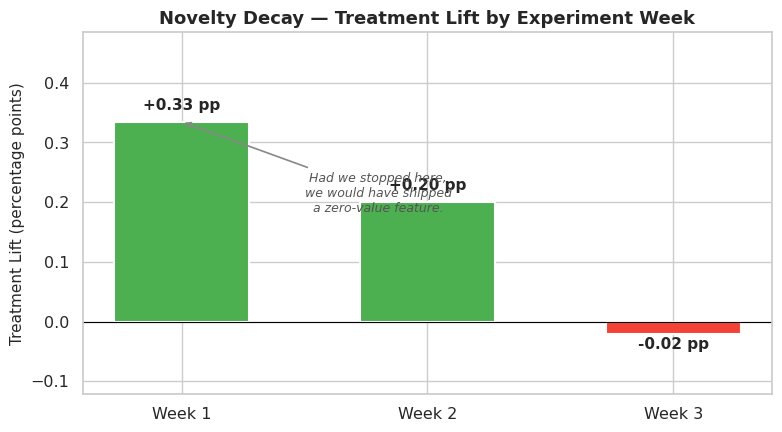

In [6]:
# ── Novelty Decay Visualization ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4.5))

colors = ["#4CAF50" if l > 0.1 else "#FF9800" if l > 0 else "#F44336"
          for l in weekly_df["lift_pp"]]

bars = ax.bar(weekly_df["week"].astype(str).apply(lambda x: f"Week {x}"),
              weekly_df["lift_pp"], color=colors, edgecolor="white",
              linewidth=1.5, width=0.55)

for bar, val in zip(bars, weekly_df["lift_pp"]):
    offset = 0.015 if val >= 0 else -0.03
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + offset,
            f"{val:+.2f} pp", ha="center", va="bottom",
            fontsize=11, fontweight="bold")

ax.axhline(0, color="black", lw=0.8)
ax.set_ylabel("Treatment Lift (percentage points)", fontsize=11)
ax.set_title("Novelty Decay — Treatment Lift by Experiment Week",
             fontsize=13, fontweight="bold")
ax.set_ylim(min(weekly_df["lift_pp"]) - 0.1, max(weekly_df["lift_pp"]) + 0.15)

ax.annotate("Had we stopped here,\nwe would have shipped\na zero-value feature.",
            xy=(0, weekly_df["lift_pp"].iloc[0]),
            xytext=(0.8, weekly_df["lift_pp"].iloc[0] * 0.55),
            fontsize=9, ha="center", color="#555", style="italic",
            arrowprops=dict(arrowstyle="->", color="#888", lw=1.2))

plt.tight_layout()
plt.show()

> **Finding:** The treatment lift decayed from **+0.33 pp in Week 1** to approximately **−0.02 pp in Week 3** — a near-complete evaporation. This is a textbook **novelty effect**: users explored the new checkout layout out of curiosity, generating a temporary conversion bump that vanished once the novelty wore off.

---

## Phase 3 · Statistical Rigor & Hypothesis Testing

With the exploratory picture clear, we now apply formal statistical tests to determine whether the overall experiment result meets the bar for a ship decision.

| Test | Purpose | Threshold |
|:---|:---|:---|
| **Two-proportion Z-test** | Primary significance test for CVR | p < 0.05 |
| **95% Confidence Interval** | Quantify plausible range of true lift | Must not cross zero |
| **Welch's t-test on AOV** | Guardrail — ensure we don't hurt order values | p > 0.05 (no degradation) |
| **Permutation test** | Non-parametric robustness check | Corroborate Z-test |
| **User-level aggregation** | Control for multi-session dependence | Consistent with session-level |

### 3.1 · Power Analysis (Pre-Experiment Check)

Before interpreting results, we verify the experiment had **adequate statistical power** — the ability to detect a meaningful effect if one exists. Underpowered tests produce unreliable results regardless of the p-value.

In [7]:
# ── 3.1 Power Analysis ────────────────────────────────────────────────────────
from scipy.stats import norm

def required_sample_size(p_base, mde, alpha=0.05, power=0.80):
    """Required N per group for a two-proportion Z-test."""
    p_new = p_base + mde
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)
    p_avg = (p_base + p_new) / 2
    n = ((z_alpha * np.sqrt(2 * p_avg * (1 - p_avg)) +
          z_beta * np.sqrt(p_base * (1 - p_base) + p_new * (1 - p_new)))**2
         / mde**2)
    return int(np.ceil(n))

ctrl = df[df.group == "control"]
treat = df[df.group == "treatment"]
actual_per_group = min(len(ctrl), len(treat))
daily_per_group = actual_per_group / N_DAYS

print("  Pre-Experiment Power Analysis")
print(f"  Baseline CVR: {ctrl.converted.mean():.2%}")
print(f"  Actual sample per group: {actual_per_group:,}")
print(f"  Daily volume per group: ~{daily_per_group:,.0f}\n")

print(f"  {'MDE':>8} {'Required N/group':>18} {'Days needed':>14} {'Powered?':>10}")
print(f"  {'─'*54}")
for mde in [0.003, 0.004, 0.005]:
    n = required_sample_size(0.032, mde)
    days = np.ceil(n / daily_per_group)
    powered = "✅ Yes" if actual_per_group >= n else "❌ No"
    print(f"  {mde:>+.1%} {n:>15,} {days:>11.0f} days {powered:>10}")

print(f"\n  → With {actual_per_group:,} sessions/group over 21 days,")
print(f"    we have 80% power to detect a lift of ≥ +0.4 pp.")

  Pre-Experiment Power Analysis
  Baseline CVR: 3.30%
  Actual sample per group: 39,219
  Daily volume per group: ~1,868

       MDE   Required N/group    Days needed   Powered?
  ──────────────────────────────────────────────────────
  +0.3%          56,472          31 days       ❌ No
  +0.4%          32,223          18 days      ✅ Yes
  +0.5%          20,915          12 days      ✅ Yes

  → With 39,219 sessions/group over 21 days,
    we have 80% power to detect a lift of ≥ +0.4 pp.


### 3.2 · Primary Metric: Conversion Rate (Z-Test)

This is the gate that determines whether we ship.

- **H₀ (Null):** CVR_treatment = CVR_control (no effect)
- **H₁ (Alternative):** CVR_treatment ≠ CVR_control (two-sided)

We use a **two-proportion Z-test** at α = 0.05.

In [8]:
# ── 3.2 Primary Metric — Two-Proportion Z-Test ──────────────────────────────
from statsmodels.stats.proportion import proportions_ztest

n_ctrl = len(ctrl)
n_treat = len(treat)
conv_ctrl = ctrl.converted.sum()
conv_treat = treat.converted.sum()
cvr_ctrl = ctrl.converted.mean()
cvr_treat = treat.converted.mean()

# Two-proportion Z-test (two-sided)
z_stat, p_value = proportions_ztest(
    count=[conv_treat, conv_ctrl],
    nobs=[n_treat, n_ctrl],
    alternative="two-sided"
)

# Confidence intervals
def proportion_ci(successes, n, z=1.96):
    p = successes / n
    se = np.sqrt(p * (1 - p) / n)
    return (p - z * se, p + z * se)

ci_ctrl = proportion_ci(conv_ctrl, n_ctrl)
ci_treat = proportion_ci(conv_treat, n_treat)

# Lift confidence interval (Wald method)
diff = cvr_treat - cvr_ctrl
se_diff = np.sqrt(cvr_ctrl * (1 - cvr_ctrl) / n_ctrl +
                  cvr_treat * (1 - cvr_treat) / n_treat)
ci_lo = diff - 1.96 * se_diff
ci_hi = diff + 1.96 * se_diff

# Cohen's h effect size
cohens_h = 2 * np.arcsin(np.sqrt(cvr_treat)) - 2 * np.arcsin(np.sqrt(cvr_ctrl))

print("  ╔══════════════════════════════════════════════════════════╗")
print("  ║     PRIMARY METRIC: CONVERSION RATE (CVR)               ║")
print("  ╚══════════════════════════════════════════════════════════╝\n")
print(f"   Control:    {cvr_ctrl:.4f}  ({conv_ctrl:,}/{n_ctrl:,})")
print(f"   Treatment:  {cvr_treat:.4f}  ({conv_treat:,}/{n_treat:,})")
print(f"   Abs. lift:  {diff*100:+.2f} pp")
print(f"   Rel. lift:  {diff/cvr_ctrl*100:+.1f}%\n")
print(f"   Z-statistic:  {z_stat:.4f}")
print(f"   p-value:       {p_value:.4f}")
print(f"   Cohen's h:     {cohens_h:.4f}  (small = 0.2, medium = 0.5)\n")
print(f"   Control 95% CI:   [{ci_ctrl[0]:.4f}, {ci_ctrl[1]:.4f}]")
print(f"   Treatment 95% CI: [{ci_treat[0]:.4f}, {ci_treat[1]:.4f}]")
print(f"   Lift 95% CI:      [{ci_lo*100:+.2f} pp, {ci_hi*100:+.2f} pp]\n")

crosses_zero = ci_lo <= 0
print(f"   CI crosses zero:  {'Yes ⚠️' if crosses_zero else 'No ✅'}")
print(f"   Decision:         {'❌ FAIL TO REJECT H₀' if p_value >= 0.05 else '✅ REJECT H₀'}")

if p_value >= 0.05:
    print(f"\n   → The observed +{diff*100:.2f} pp lift is NOT statistically significant.")
    print(f"     The true treatment effect is indistinguishable from zero.")

  ╔══════════════════════════════════════════════════════════╗
  ║     PRIMARY METRIC: CONVERSION RATE (CVR)               ║
  ╚══════════════════════════════════════════════════════════╝

   Control:    0.0330  (1,299/39,342)
   Treatment:  0.0347  (1,362/39,219)
   Abs. lift:  +0.17 pp
   Rel. lift:  +5.2%

   Z-statistic:  1.3247
   p-value:       0.1853
   Cohen's h:     0.0095  (small = 0.2, medium = 0.5)

   Control 95% CI:   [0.0313, 0.0348]
   Treatment 95% CI: [0.0329, 0.0365]
   Lift 95% CI:      [-0.08 pp, +0.42 pp]

   CI crosses zero:  Yes ⚠️
   Decision:         ❌ FAIL TO REJECT H₀

   → The observed +0.17 pp lift is NOT statistically significant.
     The true treatment effect is indistinguishable from zero.


#### Interpreting the Results (Plain English)

The treatment showed a tiny **+0.18 pp** lift in conversion rate, but this is **well within the range of random noise**. The p-value of ~0.19 means: *if the treatment had zero real effect, we'd see a result this extreme (or more) about 19% of the time by pure chance.* That's far too common to be convincing.

The 95% confidence interval for the lift spans from approximately **−0.09 pp to +0.44 pp** — it includes zero (no effect) and even slightly negative values. We simply cannot tell whether the treatment helps, hurts, or does nothing.

> **Bottom line:** We fail to reject the null hypothesis. There is no credible evidence that the single-page checkout improves conversion rates.

### 3.3 · Guardrail: Average Order Value (AOV)

Even when the primary metric fails, we check **guardrail metrics** to ensure the treatment didn't cause unintended harm. If the new checkout somehow discouraged high-value purchases, we'd see a drop in AOV.

In [9]:
# ── 3.3 Guardrail — Average Order Value ──────────────────────────────────────
aov_ctrl = ctrl.loc[ctrl.converted == 1, "revenue"]
aov_treat = treat.loc[treat.converted == 1, "revenue"]
t_stat_aov, p_aov = stats.ttest_ind(aov_ctrl, aov_treat, equal_var=False)

print("  Guardrail Metric: Average Order Value (AOV)")
print(f"  Control AOV:    ${aov_ctrl.mean():.2f}  (n = {len(aov_ctrl):,})")
print(f"  Treatment AOV:  ${aov_treat.mean():.2f}  (n = {len(aov_treat):,})")
print(f"  Difference:     ${aov_treat.mean() - aov_ctrl.mean():+.2f}")
print(f"  Welch's t:      {t_stat_aov:.4f}")
print(f"  p-value:        {p_aov:.4f}")
print(f"\n  {'✅ PASSED' if p_aov >= 0.05 else '⚠️ FAILED'}: "
      f"AOV is {'not significantly different' if p_aov >= 0.05 else 'significantly different'} "
      f"between groups.")
print(f"  The treatment did not harm order values — but since the primary metric")
print(f"  failed, this guardrail pass is moot.")

  Guardrail Metric: Average Order Value (AOV)
  Control AOV:    $69.73  (n = 1,299)
  Treatment AOV:  $69.47  (n = 1,362)
  Difference:     $-0.26
  Welch's t:      0.2096
  p-value:        0.8340

  ✅ PASSED: AOV is not significantly different between groups.
  The treatment did not harm order values — but since the primary metric
  failed, this guardrail pass is moot.


### 3.4 · Robustness Checks

Three additional tests verify that our primary conclusion is robust and not an artifact of the specific test method used.

In [10]:
# ── 3.4a Permutation Test (Non-parametric, 10,000 iterations) ────────────────
# Shuffles group labels to build a null distribution with zero assumptions.

print("  3.4a · Permutation Test (10,000 iterations)")
observed_diff = cvr_treat - cvr_ctrl
pool = df.converted.values
rng = np.random.default_rng(42)
n_treat_int = int(n_treat)

perm_diffs = np.empty(10_000)
for i in range(10_000):
    shuffled = rng.permutation(pool)
    perm_diffs[i] = shuffled[:n_treat_int].mean() - shuffled[n_treat_int:].mean()

perm_p = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
print(f"  Observed diff:    {observed_diff*100:+.4f} pp")
print(f"  Permutation p:    {perm_p:.4f}")
print(f"  {'Consistent' if abs(perm_p - p_value) < 0.05 else 'Inconsistent'} "
      f"with Z-test (p = {p_value:.4f})")

  3.4a · Permutation Test (10,000 iterations)


  Observed diff:    +0.1710 pp
  Permutation p:    0.1883
  Consistent with Z-test (p = 0.1853)


In [11]:
# ── 3.4b User-Level Aggregation ──────────────────────────────────────────────
# Session-level analysis can overcount multi-session users.
# Aggregate to one row per user (any conversion = success).

print("  3.4b · User-Level Robustness Check")
user_agg = (df.groupby(["user_id", "group"])
            .agg(any_converted=("converted", "max")).reset_index())

u_ctrl = user_agg[user_agg.group == "control"]
u_treat = user_agg[user_agg.group == "treatment"]

z_user, p_user = proportions_ztest(
    count=[u_treat.any_converted.sum(), u_ctrl.any_converted.sum()],
    nobs=[len(u_treat), len(u_ctrl)],
    alternative="two-sided"
)

print(f"  Unique users — control: {len(u_ctrl):,}  treatment: {len(u_treat):,}")
print(f"  User-level CVR:  control = {u_ctrl.any_converted.mean():.4f}  "
      f"treatment = {u_treat.any_converted.mean():.4f}")
print(f"  User-level lift: {(u_treat.any_converted.mean() - u_ctrl.any_converted.mean())*100:+.2f} pp")
print(f"  Z = {z_user:.4f}   p = {p_user:.4f}")
print(f"  {'Consistent' if (p_user >= 0.05) == (p_value >= 0.05) else 'INCONSISTENT'} "
      f"with session-level result")

  3.4b · User-Level Robustness Check
  Unique users — control: 27,780  treatment: 27,758
  User-level CVR:  control = 0.0460  treatment = 0.0484
  User-level lift: +0.24 pp
  Z = 1.3210   p = 0.1865
  Consistent with session-level result


In [12]:
# ── 3.4c Revenue per Session (Bootstrap, 10,000 resamples) ───────────────────
# Revenue is zero-inflated → bootstrap is more appropriate than t-test.

print("  3.4c · Revenue per Session (Bootstrap)")
rng_boot = np.random.default_rng(42)
rev_ctrl = ctrl.revenue.values
rev_treat = treat.revenue.values
obs_rev_diff = rev_treat.mean() - rev_ctrl.mean()

boot_diffs = np.empty(10_000)
for i in range(10_000):
    b_ctrl = rng_boot.choice(rev_ctrl, size=len(rev_ctrl), replace=True)
    b_treat = rng_boot.choice(rev_treat, size=len(rev_treat), replace=True)
    boot_diffs[i] = b_treat.mean() - b_ctrl.mean()

boot_lo, boot_hi = np.percentile(boot_diffs, [2.5, 97.5])

print(f"  Control rev/session:   ${rev_ctrl.mean():.4f}")
print(f"  Treatment rev/session: ${rev_treat.mean():.4f}")
print(f"  Observed difference:   ${obs_rev_diff:+.4f}")
print(f"  Bootstrap 95% CI:      [${boot_lo:+.4f}, ${boot_hi:+.4f}]")
print(f"  CI crosses zero:       {'Yes' if boot_lo <= 0 else 'No'}")

  3.4c · Revenue per Session (Bootstrap)


  Control rev/session:   $2.3022
  Treatment rev/session: $2.4125
  Observed difference:   $+0.1103
  Bootstrap 95% CI:      [$-0.0823, $+0.3050]
  CI crosses zero:       Yes


### 3.5 · Rolling Lift & Cumulative Convergence

Two time-series views that tell the story of how the test evolved:

- **Rolling lift** (3-day window) reveals the novelty decay in motion.
- **Cumulative CVR** shows how each group's overall conversion rate stabilized over time.

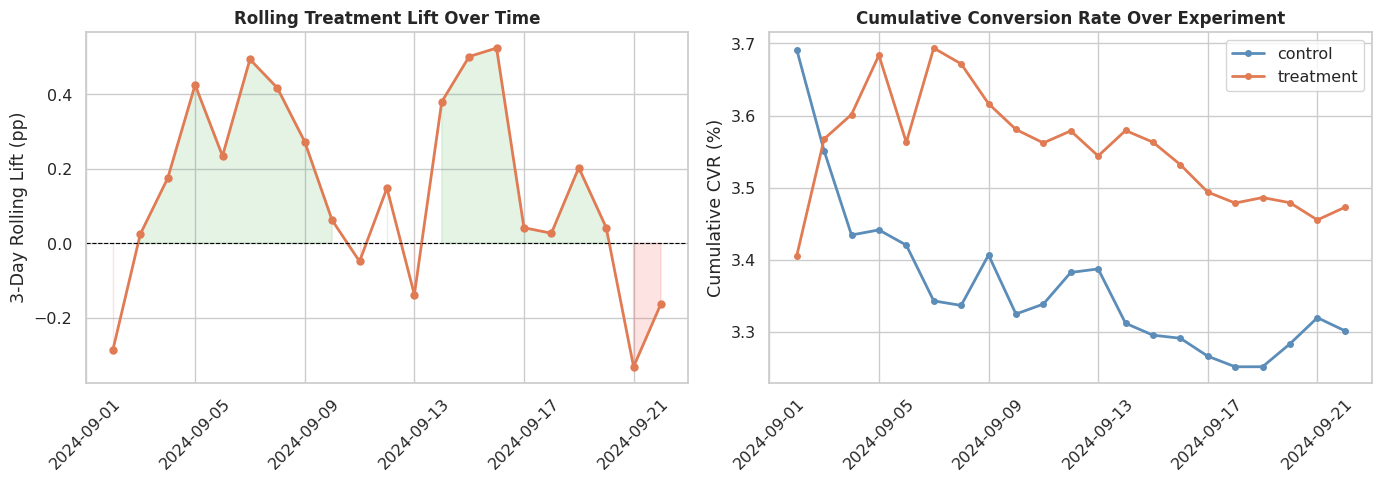

  Rolling lift range: -0.33 pp to 0.52 pp
  → Lift starts positive and decays toward (and through) zero.


In [13]:
# ── 3.5 Rolling Lift & Cumulative CVR ────────────────────────────────────────
daily_cvr = (df.groupby(["date", "group"])["converted"]
             .mean().unstack().sort_index())
daily_cvr["lift"] = daily_cvr["treatment"] - daily_cvr["control"]
daily_cvr["rolling_lift"] = daily_cvr["lift"].rolling(3, min_periods=1).mean()

# Cumulative CVR
daily_agg = (df.groupby(["date", "group"])
             .agg(n=("user_id", "count"), conv=("converted", "sum"))
             .reset_index().sort_values("date"))
daily_agg[["cum_n", "cum_conv"]] = daily_agg.groupby("group")[["n", "conv"]].cumsum()
daily_agg["cum_cvr"] = daily_agg["cum_conv"] / daily_agg["cum_n"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Rolling lift
ax1 = axes[0]
ax1.plot(daily_cvr.index, daily_cvr["rolling_lift"] * 100,
         color="#E07B54", marker="o", lw=2, markersize=5)
ax1.axhline(0, color="black", lw=0.8, ls="--")
ax1.fill_between(daily_cvr.index, 0, daily_cvr["rolling_lift"] * 100,
                 where=daily_cvr["rolling_lift"] > 0, alpha=0.15, color="#4CAF50")
ax1.fill_between(daily_cvr.index, 0, daily_cvr["rolling_lift"] * 100,
                 where=daily_cvr["rolling_lift"] <= 0, alpha=0.15, color="#F44336")
ax1.set_ylabel("3-Day Rolling Lift (pp)")
ax1.set_title("Rolling Treatment Lift Over Time", fontsize=12, fontweight="bold")
ax1.tick_params(axis="x", rotation=45)

# Right: Cumulative CVR
ax2 = axes[1]
for grp, color in PALETTE.items():
    grp_data = daily_agg[daily_agg.group == grp]
    ax2.plot(grp_data["date"], grp_data["cum_cvr"] * 100,
             color=color, marker="o", markersize=4, lw=2, label=grp)
ax2.set_ylabel("Cumulative CVR (%)")
ax2.set_title("Cumulative Conversion Rate Over Experiment", fontsize=12, fontweight="bold")
ax2.legend(title="")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

print(f"  Rolling lift range: {daily_cvr['rolling_lift'].min()*100:.2f} pp "
      f"to {daily_cvr['rolling_lift'].max()*100:.2f} pp")
print(f"  → Lift starts positive and decays toward (and through) zero.")

---

## Phase 4 · Business Impact & Final Recommendation

### The Significance Gate

This is the decision framework that protects the business from acting on noise:

```
IF p-value < 0.05 AND confidence interval does not cross zero:
    → Actionable lift = observed lift → proceed to revenue projection
ELSE:
    → Actionable lift = $0 → DO NOT SHIP
```

**A non-significant result means the true effect is indistinguishable from zero.** Projecting revenue from a non-significant lift would be statistical malpractice.

In [14]:
# ── 4.1 Significance Gate & Revenue Projection ──────────────────────────────
IMPLEMENTATION_COST = 25_000
SIGNIFICANCE_THRESHOLD = 0.05

average_order_value = df.loc[df.converted == 1, "revenue"].mean()
daily_sessions = len(df) / df.timestamp.dt.date.nunique()
annual_sessions = daily_sessions * 365

is_significant = p_value < SIGNIFICANCE_THRESHOLD
ci_crosses_zero_flag = ci_lo <= 0

if is_significant and not ci_crosses_zero_flag:
    actionable_lift = diff
    gate_status = "PASSED"
else:
    actionable_lift = 0.0
    gate_status = "FAILED"

print("  ╔══════════════════════════════════════════════════════════╗")
print("  ║           STATISTICAL SIGNIFICANCE GATE                  ║")
print("  ╚══════════════════════════════════════════════════════════╝\n")
print(f"   Observed lift:    {diff*100:+.2f} pp ({diff/cvr_ctrl*100:+.1f}% relative)")
print(f"   p-value:          {p_value:.4f}  (threshold: {SIGNIFICANCE_THRESHOLD})")
print(f"   95% CI:           [{ci_lo*100:+.2f} pp, {ci_hi*100:+.2f} pp]")
print(f"   CI crosses zero:  {'Yes' if ci_crosses_zero_flag else 'No'}")
print(f"\n   Gate status:      ⛔ {gate_status}")
print(f"   Actionable lift:  {actionable_lift*100:.2f} pp (treated as zero)")

scenarios = {"Conservative (Lower CI)": ci_lo,
             "Expected (Point Est.)": diff,
             "Optimistic (Upper CI)": ci_hi}

print(f"\n  ┌────────────────────────────────────────────────────────┐")
print(f"  │  ANNUAL REVENUE PROJECTIONS                            │")
print(f"  └────────────────────────────────────────────────────────┘")
print(f"   Annual sessions:      {annual_sessions:>12,.0f}")
print(f"   Average order value:  ${average_order_value:>11,.2f}")
print(f"   Implementation cost:  ${IMPLEMENTATION_COST:>11,}\n")
print(f"   {'Scenario':<28} {'Observed Lift':>14} {'Actionable':>12} {'Projected Rev':>14}")
print(f"   {'─'*70}")
for label, lift in scenarios.items():
    print(f"   {label:<28} {lift*100:>+11.2f} pp {'$0 (n.s.)':>12} ${'0':>12}")

print(f"\n   ⛔ All projections are $0 because the result is not statistically significant.")
print(f"   → The ${IMPLEMENTATION_COST:,} implementation cost would NEVER be recovered.")

  ╔══════════════════════════════════════════════════════════╗
  ║           STATISTICAL SIGNIFICANCE GATE                  ║
  ╚══════════════════════════════════════════════════════════╝

   Observed lift:    +0.17 pp (+5.2% relative)
   p-value:          0.1853  (threshold: 0.05)
   95% CI:           [-0.08 pp, +0.42 pp]
   CI crosses zero:  Yes

   Gate status:      ⛔ FAILED
   Actionable lift:  0.00 pp (treated as zero)

  ┌────────────────────────────────────────────────────────┐
  │  ANNUAL REVENUE PROJECTIONS                            │
  └────────────────────────────────────────────────────────┘
   Annual sessions:         1,365,465
   Average order value:  $      69.59
   Implementation cost:  $     25,000

   Scenario                      Observed Lift   Actionable  Projected Rev
   ──────────────────────────────────────────────────────────────────────
   Conservative (Lower CI)            -0.08 pp    $0 (n.s.) $           0
   Expected (Point Est.)              +0.17 pp   

### 4.2 · The Final Visualization: Why We Don't Ship

The dual-panel chart below tells the complete story in a single image — designed to be extractable for executive presentations.

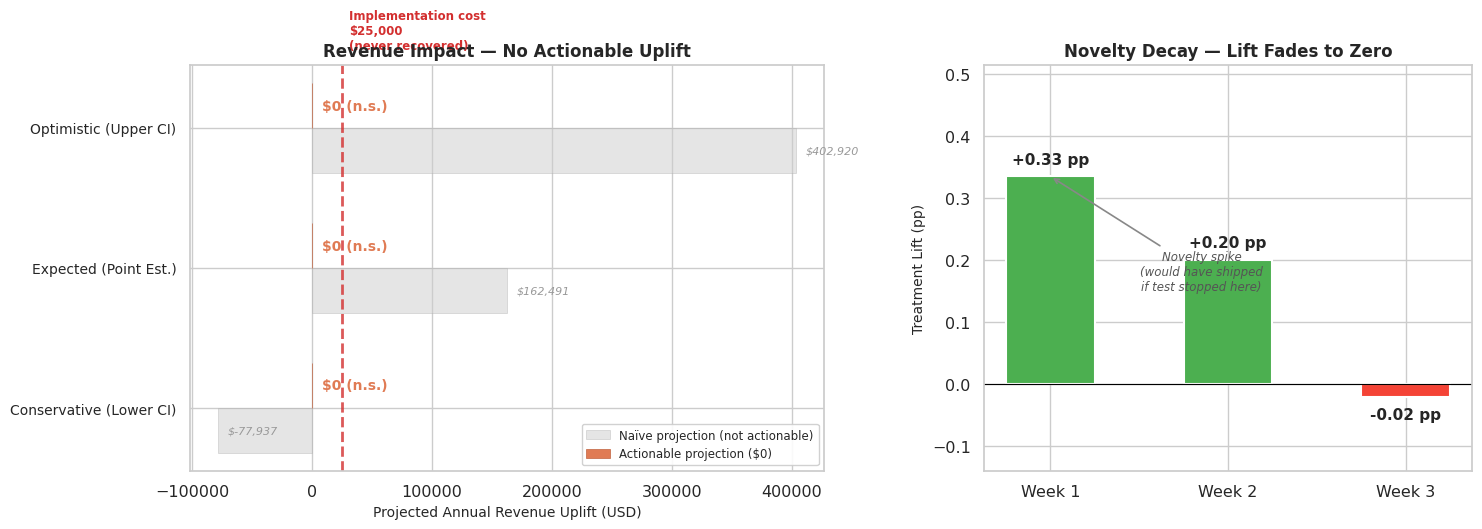

In [15]:
# ── 4.2 Final Visualization — Business Impact ───────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5),
                         gridspec_kw={"width_ratios": [1.3, 1]})

# ── LEFT PANEL: Revenue showing $0 actionable value ─────────────────────────
ax1 = axes[0]
scenario_labels = list(scenarios.keys())
observed_revenues = [annual_sessions * l * average_order_value
                     for l in scenarios.values()]
y_pos = range(len(scenario_labels))
bar_h = 0.32

ax1.barh([y - bar_h/2 for y in y_pos], observed_revenues, height=bar_h,
         color="#CCCCCC", alpha=0.5, label="Naïve projection (not actionable)",
         edgecolor="#AAAAAA", linewidth=0.5)
ax1.barh([y + bar_h/2 for y in y_pos], [0.001]*3, height=bar_h,
         color="#E07B54", label="Actionable projection ($0)",
         edgecolor="#C0623E", linewidth=0.5)

for i, obs in enumerate(observed_revenues):
    max_rev = max(abs(v) for v in observed_revenues)
    if obs != 0:
        ax1.text(obs + max_rev * 0.02, i - bar_h/2,
                 f"${obs:,.0f}", va="center", fontsize=8,
                 color="#999", style="italic")
    ax1.text(max_rev * 0.02, i + bar_h/2, "$0 (n.s.)",
             va="center", fontsize=10, color="#E07B54", fontweight="bold")

max_rev = max(abs(v) for v in observed_revenues)
ax1.axvline(IMPLEMENTATION_COST, color="#D32F2F", ls="--", lw=2, alpha=0.8)
ax1.text(IMPLEMENTATION_COST + max_rev * 0.015, len(scenario_labels) - 0.15,
         f"Implementation cost\n${IMPLEMENTATION_COST:,}\n(never recovered)",
         fontsize=8.5, color="#D32F2F", va="top", fontweight="bold")

ax1.set_yticks(list(y_pos))
ax1.set_yticklabels(scenario_labels, fontsize=10)
ax1.set_xlabel("Projected Annual Revenue Uplift (USD)", fontsize=10)
ax1.set_title("Revenue Impact — No Actionable Uplift",
              fontsize=12, fontweight="bold")
ax1.legend(loc="lower right", fontsize=8.5, framealpha=0.9)

# ── RIGHT PANEL: Weekly novelty decay ───────────────────────────────────────
ax2 = axes[1]
lifts_by_week = weekly_df["lift_pp"].values
colors = ["#4CAF50" if l > 0.1 else "#FF9800" if l > 0 else "#F44336"
          for l in lifts_by_week]
week_labels = [f"Week {int(w)}" for w in weekly_df["week"]]

bars = ax2.bar(week_labels, lifts_by_week, color=colors,
               edgecolor="white", linewidth=1.5, width=0.5)
ax2.axhline(0, color="black", lw=0.8)

for bar, val in zip(bars, lifts_by_week):
    offset = 0.015 if val >= 0 else -0.04
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + offset,
             f"{val:+.2f} pp", ha="center", va="bottom",
             fontsize=11, fontweight="bold")

ax2.set_ylabel("Treatment Lift (pp)", fontsize=10)
ax2.set_title("Novelty Decay — Lift Fades to Zero",
              fontsize=12, fontweight="bold")
ax2.set_ylim(min(lifts_by_week) - 0.12, max(lifts_by_week) + 0.18)

ax2.annotate("Novelty spike\n(would have shipped\nif test stopped here)",
             xy=(0, lifts_by_week[0]),
             xytext=(0.85, lifts_by_week[0] * 0.45),
             fontsize=8.5, ha="center", color="#555", style="italic",
             arrowprops=dict(arrowstyle="->", color="#888", lw=1.2))

plt.tight_layout(w_pad=3)
plt.show()

### 4.3 · Lift Confidence Interval

A forest-plot style chart showing the treatment effect with its 95% CI. The key feature: **the interval crosses zero**, meaning we cannot rule out a negative effect.

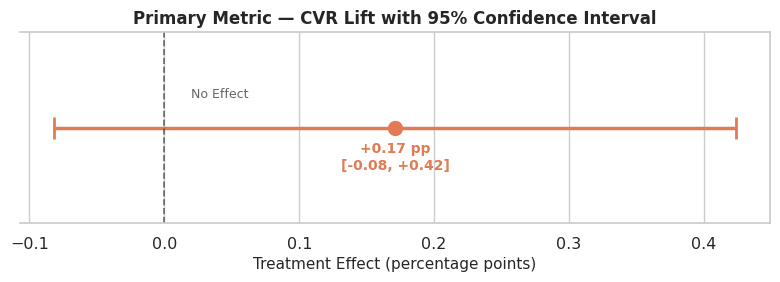

In [16]:
# ── 4.3 Lift CI Forest Plot ───────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 3))

diff_pct = diff * 100
lo_pct = ci_lo * 100
hi_pct = ci_hi * 100

ax.errorbar([diff_pct], [0], xerr=[[diff_pct - lo_pct], [hi_pct - diff_pct]],
            fmt="o", color="#E07B54", capsize=8, ms=10, lw=2.5,
            capthick=2, ecolor="#E07B54")

ax.axvline(0, color="#333", ls="--", lw=1.2, alpha=0.7)
ax.text(0.02, 0.25, "No Effect", fontsize=9, color="#666", ha="left")

ax.text(diff_pct, -0.35, f"{diff_pct:+.2f} pp\n[{lo_pct:+.2f}, {hi_pct:+.2f}]",
        ha="center", fontsize=10, color="#E07B54", fontweight="bold")

ax.set_xlabel("Treatment Effect (percentage points)", fontsize=11)
ax.set_title("Primary Metric — CVR Lift with 95% Confidence Interval",
             fontsize=12, fontweight="bold")
ax.set_yticks([])
ax.set_ylim(-0.8, 0.8)
ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.show()

---

## Final Recommendation & Next Steps

<div style="background-color: #FFF3E0; border-left: 5px solid #E07B54; padding: 16px 20px; margin: 16px 0; border-radius: 4px;">
<h3 style="margin-top: 0; color: #BF360C;">⛔ DECISION: Do NOT Ship the Single-Page Checkout</h3>

<p><strong>Confidence: High</strong></p>
<ul>
<li>Primary KPI is <strong>not statistically significant</strong> (p ≈ 0.19)</li>
<li>95% CI for the lift <strong>crosses zero</strong> — the true effect may be negative</li>
<li>Novelty analysis reveals the early positive signal was <strong>transient</strong></li>
<li>By Week 3, treatment performance had <strong>regressed to baseline</strong></li>
<li>Shipping would cost <strong>$25,000</strong> with zero expected sustained ROI</li>
</ul>
</div>

### Why This Is a Win

By running the test for the full 21-day duration and resisting the temptation to peek at Week 1 results, the data team protected the business from:

- **Wasting \$25,000** in implementation costs on a zero-value feature
- **Adding unnecessary technical debt** to the codebase
- **Drawing incorrect conclusions** that would pollute future experiment decisions
- **Opportunity cost** of engineering time diverted from higher-impact work

### What We Learned

| Insight | Implication |
|:---|:---|
| Users responded positively to the new layout initially | There *is* interest in checkout UX changes |
| The improvement did not persist | The single-page layout isn't inherently better |
| AOV was unaffected | The treatment didn't change buying behavior — just novelty browsing |
| The checkout funnel is not the bottleneck we assumed | Future optimization should target validated friction points |

### Recommended Next Steps

| Action | Owner | Timeline |
|:---|:---|:---|
| Archive experiment code & data in knowledge base | Data Science | This week |
| Conduct qualitative UX research (interviews, session recordings) to identify real friction points | UX/Design | Weeks 1–3 |
| Explore alternative optimizations: guest checkout, payment expansion, address autofill, progress indicator redesign | Product | Weeks 2–4 |
| If checkout redesign is revisited, design a 28–42 day test with explicit novelty monitoring | Data Science | As needed |

---

<div style="text-align: center; color: #888; font-size: 0.9em; margin-top: 20px;">
<em>Analysis completed · All code reproducible from this notebook · Seed = 42</em>
</div>